# How to win baseball games

### Introduction

Baseball is an American past time, it's full of legend and lore, instilled deep within the fabric of the American dream. To many it is more than a game. However as data scientists, we don't worry ourselves too much about the emotional aspects of things, especially when there is a quantitative advantage to be had. The name of the game is Baseball and the goal is to score runs in order to win. The question is; how do you score more runs? Luckily for us, Baseball is a sport in which statistics are meticulously recorded and scrutinized. In this notebook, we'll take the romantic aspects of the game and put them aside, we'll be using numbers and statistical analysis to build a winning team.

### The Data

The dataset we will be using Kaggle's 'The History of Baseball' which is a reformatted version of 'Lahman's Baseball Database'. It contains data from 1871 to 2015. The data is stored in the form of a small SQLite database.

In [1]:
# loading required modules 
import pandas as pd
import numpy as np
import sqlite3
conn = sqlite3.connect('/Users/robinphetsavong/Documents/robinphetsa.github.io/data_science/data-projects/Projects/Baseball/baseball/database.sqlite')
c = conn.cursor()

In [40]:
#Read in data using sql

batting_data = pd.read_sql_query("SELECT t.team_id,b.year,t.w as wins,t.l as losses,SUM(b.r) as runs,SUM(b.h) as hits,SUM(b.ab) as atbats,SUM(b.sf) as sacflies,SUM(b.hbp) as hitbypitch,SUM(b.bb) as baseonballs,SUM(b.double) as doubles,SUM(b.triple) as triples,SUM(b.hr) as hr,SUM(b.rbi) as rbi,SUM(b.sb) as sb,SUM(s.salary) as payroll FROM batting b INNER JOIN team t on b.team_id = t.team_id and b.year = t.year LEFT JOIN salary s on b.team_id = s.team_id and b.year = s.year and b.player_id = s.player_id GROUP BY t.team_id, b.year ORDER BY b.year, t.team_id;", conn)

In [41]:
batting_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2805 entries, 0 to 2804
Data columns (total 16 columns):
team_id        2805 non-null object
year           2805 non-null int64
wins           2805 non-null int64
losses         2805 non-null int64
runs           2805 non-null float64
hits           2805 non-null float64
atbats         2805 non-null float64
sacflies       2805 non-null float64
hitbypitch     2805 non-null float64
baseonballs    2805 non-null float64
doubles        2805 non-null float64
triples        2805 non-null float64
hr             2805 non-null float64
rbi            2805 non-null float64
sb             2805 non-null float64
payroll        888 non-null float64
dtypes: float64(12), int64(3), object(1)
memory usage: 350.7+ KB


### Feature Engineering

We'll be adding three more statistics to the dataframe:
* Batting Average
* On Base Percentage
* Slugging Percentage
* On Base and Slugging Percentage

#### Batting Average

In [25]:
# create a function that calculates the batting average
def get_bavg(x):
    H = x['hits']
    AB = x['atbats']
    if AB == 0 or H == 0:
        return 0
    else:
        return H/AB

In [42]:
# apply the function to our dataframe
batting_data['ba'] = batting_data.apply(get_bavg, axis=1)

##### On Base Percentage

In [27]:
# define a function to calculate the OBP that takes in a dataframe as a parameter
def get_obp(x):
    H = x['hits']
    BB = x['baseonballs']
    HBP = x['hitbypitch']
    SF = x['sacflies']
    AB = x['atbats']
    Denominator = (AB+BB+HBP+SF)
#    if Denominator == 0:
#        Denominator = 0.001 #prevent python from approximating to zero and getting div by zero errors
    if AB == 0:
        return 0
    else:
        return (H+BB+HBP)/Denominator

In [43]:
batting_data['obp'] = batting_data.apply(get_obp, axis=1)

##### Singles

In [29]:
# Function to calculate singles
def get_singles(x):
    H = x['hits']
    doubles = x['doubles']
    triples = x['triples']
    HR = x['hr']
    singles = H-(doubles-triples-HR)
    if singles <=0:
        return 0
    else:
        return singles

In [44]:
batting_data['singles'] = batting_data.apply(get_singles, axis=1)

##### Slugging Percentage

In [33]:
def get_slg(x):
    H = x['hits']
    doubles = x['doubles']
    triples = x['triples']
    HR = x['hr']
    singles = x['singles']
    AB = x['atbats']
    if AB == 0:
        return 0
    else:
        return (singles + 2*doubles + 3*triples + 4*HR)/(AB)

In [45]:
batting_data['slg'] = batting_data.apply(get_slg,axis=1)

#### On-base plus slugging

In [54]:
def get_ops(x):
    obp = x['obp']
    slg = x['slg']
    return obp+slg

In [55]:
batting_data['ops'] = batting_data.apply(get_ops,axis=1)

In [56]:
# Lets check our data

batting_data.head(7)

,team_id,year,wins,losses,runs,hits,atbats,sacflies,hitbypitch,baseonballs,...,triples,hr,rbi,sb,payroll,ba,obp,singles,slg,ops
0,BS1,1871,20,10,401,426,1372,0,0,60,...,37,3,267,73,NaN,0.310496,0.339385,396,0.480321,0.819706
1,CH1,1871,19,9,302,323,1196,0,0,60,...,21,10,193,69,NaN,0.270067,0.304936,302,0.425585,0.730522
2,CL1,1871,10,19,249,328,1186,0,0,26,...,40,7,164,18,NaN,0.276560,0.292079,340,0.470489,0.762568
3,FW1,1871,7,12,137,178,746,0,0,33,...,8,2,94,16,NaN,0.238606,0.270860,169,0.320375,0.591235
4,NY2,1871,16,17,302,403,1404,0,0,33,...,21,1,213,46,NaN,0.287037,0.303410,382,0.381054,0.684464
5,PH1,1871,21,7,376,410,1281,0,0,46,...,27,9,250,56,NaN,0.320062,0.343632,380,0.491023,0.834655
6,RC1,1871,4,21,231,274,1036,0,0,38,...,25,3,147,53,NaN,0.264479,0.290503,258,0.417954,0.708456


#### Cleaning up the dataframe

In [47]:
batting_data['runs'] = batting_data['runs'].astype(int)
batting_data['hits'] = batting_data['hits'].astype(int)
batting_data['atbats'] = batting_data['atbats'].astype(int)
batting_data['sacflies'] = batting_data['sacflies'].astype(int)
batting_data['hitbypitch'] = batting_data['hitbypitch'].astype(int)
batting_data['baseonballs'] = batting_data['baseonballs'].astype(int)
batting_data['doubles'] = batting_data['doubles'].astype(int)
batting_data['triples'] = batting_data['triples'].astype(int)
batting_data['hr'] = batting_data['hr'].astype(int)
batting_data['rbi'] = batting_data['rbi'].astype(int)
batting_data['sb'] = batting_data['sb'].astype(int)
batting_data['singles'] = batting_data['singles'].astype(int)

In [57]:
batting_data.tail(7)

,team_id,year,wins,losses,runs,hits,atbats,sacflies,hitbypitch,baseonballs,...,triples,hr,rbi,sb,payroll,ba,obp,singles,slg,ops
2798,SEA,2015,76,86,656,1379,5544,35,36,478,...,22,198,624,69,122208700.0,0.248737,0.310684,1337,0.490440,0.801125
2799,SFN,2015,84,78,696,1486,5565,37,49,457,...,39,136,663,93,164701500.0,0.267026,0.326130,1373,0.469003,0.795132
2800,SLN,2015,100,62,647,1386,5484,42,66,506,...,39,137,619,69,119241500.0,0.252735,0.321089,1274,0.458607,0.779696
2801,TBA,2015,80,82,644,1383,5485,47,84,436,...,32,167,612,87,62821233.0,0.252142,0.314442,1304,0.478396,0.792837
2802,TEX,2015,88,74,751,1419,5511,54,76,503,...,32,172,707,101,143742789.0,0.257485,0.325195,1344,0.487389,0.812584
2803,TOR,2015,93,69,891,1480,5509,62,54,570,...,17,232,852,88,112992400.0,0.268651,0.339629,1421,0.547468,0.887097
2804,WAS,2015,83,79,703,1363,5428,51,44,539,...,13,177,665,57,155587472.0,0.251105,0.321016,1288,0.472550,0.793566


In [58]:
# lets take a look at the columns we have now
batting_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2805 entries, 0 to 2804
Data columns (total 21 columns):
team_id        2805 non-null object
year           2805 non-null int64
wins           2805 non-null int64
losses         2805 non-null int64
runs           2805 non-null int64
hits           2805 non-null int64
atbats         2805 non-null int64
sacflies       2805 non-null int64
hitbypitch     2805 non-null int64
baseonballs    2805 non-null int64
doubles        2805 non-null int64
triples        2805 non-null int64
hr             2805 non-null int64
rbi            2805 non-null int64
sb             2805 non-null int64
payroll        888 non-null float64
ba             2805 non-null float64
obp            2805 non-null float64
singles        2805 non-null int64
slg            2805 non-null float64
ops            2805 non-null float64
dtypes: float64(5), int64(15), object(1)
memory usage: 460.3+ KB


In [66]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt


#### Lets look at correlation between our stats

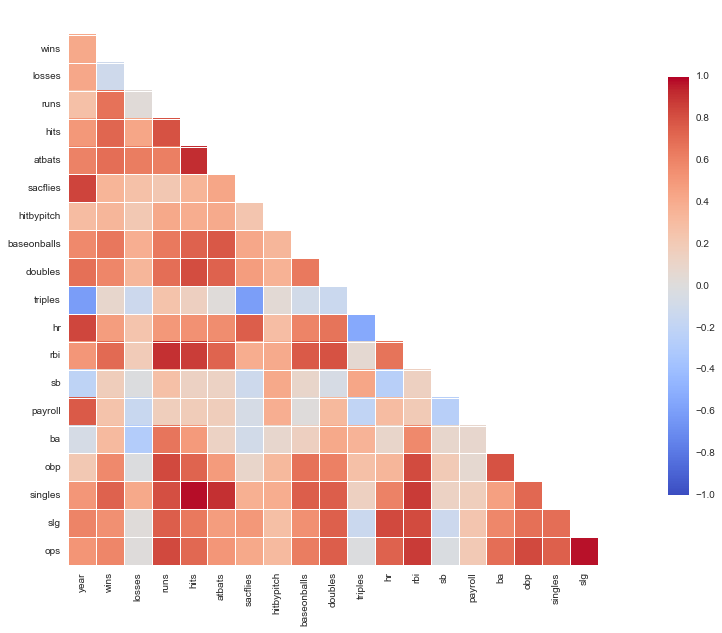

In [73]:
f, ax = plt.subplots(figsize=(15, 10))
ax = sns.corrplot(batting_data, annot=False, diag_names=False, ax=ax)

If we look at runs, we can see that OPS and SLG have a decently high correlation. It would seem that RBI is very correlated with runs, but we have to remember that runs are the result of RBI. It is often said that Correlation does not imply causation. In this cause, causation is implying a correlation between runs and RBIs.

#### Lets take a look at the correlation coefficient for each statistic in the form of a matrix

In [74]:
batting_data.corr(method='pearson')

,year,wins,losses,runs,hits,atbats,sacflies,hitbypitch,baseonballs,doubles,triples,hr,rbi,sb,payroll,ba,obp,singles,slg,ops
year,1.000000,0.418790,0.425112,0.273499,0.506073,0.605496,0.848917,0.304557,0.573027,0.683172,-0.608945,0.837723,0.512807,-0.204534,0.766774,-0.055061,0.214326,0.514578,0.598571,0.522609
wins,0.418790,1.000000,-0.102111,0.677088,0.725170,0.689208,0.343843,0.341750,0.655846,0.587950,0.088792,0.484143,0.704517,0.177468,0.253482,0.317607,0.575701,0.739162,0.539695,0.589334
losses,0.425112,-0.102111,1.000000,0.028626,0.436371,0.632162,0.266089,0.215372,0.385962,0.340660,-0.120872,0.248999,0.189485,-0.010884,-0.146479,-0.279776,-0.013835,0.417822,0.019729,0.010770
runs,0.273499,0.677088,0.028626,1.000000,0.801684,0.618811,0.222422,0.416779,0.647021,0.693323,0.253434,0.500527,0.911734,0.273657,0.166703,0.661191,0.833711,0.811389,0.754100,0.832509
hits,0.506073,0.725170,0.436371,0.801684,1.000000,0.919502,0.344272,0.392681,0.738396,0.818596,0.154963,0.532680,0.871778,0.138984,0.181334,0.496306,0.727019,0.981391,0.643624,0.715317
atbats,0.605496,0.689208,0.632162,0.618811,0.919502,1.000000,0.432979,0.412180,0.774044,0.738046,0.017983,0.558916,0.733713,0.126653,0.173067,0.132253,0.484926,0.913416,0.478449,0.514596
sacflies,0.848917,0.343843,0.266089,0.222422,0.344272,0.432979,1.000000,0.240801,0.428936,0.477897,-0.598740,0.751100,0.395397,-0.114783,-0.057353,-0.082110,0.099744,0.379582,0.507316,0.417637
hitbypitch,0.304557,0.341750,0.215372,0.416779,0.392681,0.412180,0.240801,1.000000,0.336814,0.359617,0.041027,0.289609,0.408057,0.419048,0.390610,0.084939,0.323400,0.396034,0.282937,0.315627
baseonballs,0.573027,0.655846,0.385962,0.647021,0.738396,0.774044,0.428936,0.336814,1.000000,0.647524,-0.081202,0.600900,0.770473,0.096136,0.007843,0.155731,0.678096,0.752350,0.545059,0.625050
doubles,0.683172,0.587950,0.340660,0.693323,0.818596,0.738046,0.477897,0.359617,0.647524,1.000000,-0.131638,0.666222,0.804494,-0.053250,0.323189,0.421730,0.609580,0.751405,0.743539,0.755229


The correlation coefficient denoted by R<sup>2</sup> is a measure of linearity between two variables. It's output ranges between -1 (strongly negatively correlated) to 1 (strongly positively correlated). A value of zero implies no correlation.

If we look at the runs column, we can see that besides RBIs: hits, singles and OPS (which is essentially the sum of OBP and SLG) are the highest correlated with runs. We can visualize these linear relationships using scatter plots.

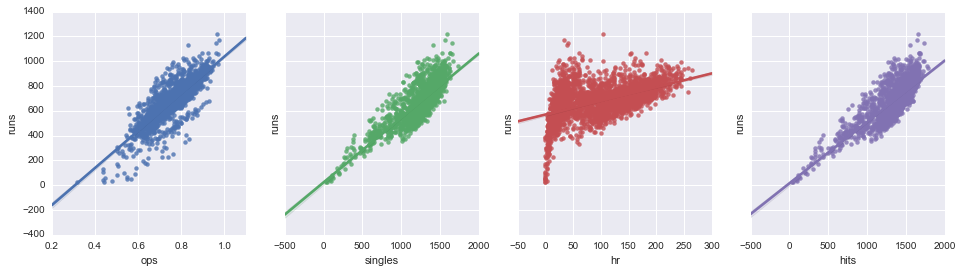

In [96]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharey=True, figsize=(16, 4))
sns.regplot(x="ops", y="runs", data=batting_data, ax=ax1)
sns.regplot(x="singles", y="runs", data=batting_data, ax=ax2)
sns.regplot(x="hr", y="runs", data=batting_data, ax=ax3)
sns.regplot(x="hits", y="runs", data=batting_data, ax=ax4)

Here we can see that OPS, Singles, and hits have a strong positive linear relationship with runs, where hr appears to be more exponetially related to runs